# FORCE LLM Hackathon November 2023 Starter Pack 

## Introduction

Large Language Models or LLMs have gained enormous amounts of attention with the advent of ChatGPT. Numerous use cases across various industries have shown their potential as generalist interfaces for various tasks.  

While LLMs have shown the ability to solve complex language based tasks such as summarization, translation, semantic search and retrieval, entity recognition, or question answering, applying them to a specific scientific or engineering domain comes with many challenges. 

Off the shelf LLMs are trained with 1000s of GPU months to years in compute resources on trillions of tokens (parts of a word) with highly specialized and curated datasets, machine learning know-how, and a whole bunch of alchemical engineering tricks.  

Natural language documents in the energy industry come in many forms and many are difficult to read, contain tables and/or figures, come in various languages, use domain specific acronyms or have handwriting which must first undergo OCR before being useful, and many more challenges. Hence creating such trillion token datasets may simply not be feasible. But is it even necessary?  

In this hackathon, a dataset has been curated by [Fabric]() that composes of data from three national repositories; the Norwegian Petroleum Directorate, the UK North Sea Transition Authority, and the Dutch Oil & Gas Reports. 

The dataset is provided as comma seperated values with a raw extracted form, and a slightly scrubbed version that has been cleaned to remove some of the most obvious issues with the datasets. This dataset forms the basis of the hackathon and is the main center of attention. 
To benefit from text-based technologies, we need good datasets, yet we do not have such high-quality datasets. Some companies may invest in creating their own - yet as we see in the world of open source, most progress in the world of machine learning and LLMs comes from sharing the know-how, the data, and the models that allow us to build new technology. Hence we emphasize the importance of generating such a dataset for the energy industry. 

The dataset we have created is a first attempt to enable advances in language models. It is not the best - it will not be the last. It is up to the community to drive its improvement, its use, and its impact. This is all but a first step into that direction.  

In this notebook, we will go through a few first examples of how we can use the dataset. The use of the dataset is by far not limited to the examples that were created therein and so I highly encourage anyone to disregard all the preprocessing, all the examples, to start from scratch, to understand deeply, to apply your best learnings, and share your results back into the open-source domain so that others may benefit and build on your shoulders. 

But now let us turn to the content of this introductory notebook and what we will do. 

1. We will explore the dataset, perform some simple analytics, and turn it into a format that is easily used for downstream machine learning tasks.
2. We will preprocess the dataset and normalize it so its content can be readily ingested into LLMs
3. We will train a continuous bag of words model (CBOW) - a word level embedding model to exemplify getting domain specific word level embeddings.
4. Going from individual words we will expand to sentences and use pre-trained models powered by Azure OpenAI to identify relationships.
5. We will then attempt to build our own sentence level embedding model and overcome the cold-start problem using OpenAIs GPT4 and a small transformer model.

None of the examples here are fleshed out, no hyper-parameters tuned, no sophisticated methods applied. None of this is the end of the road, but really the start. 

And remember it is not just about the models, but the data is where the gold may lie, how can you improve it? Make it more accesible? Make it more useful?

The data is here - what will you build?

## Setup

Before we start there is a few things that we should prepare.  
First we have created a few scripts that combine the different csv files into a single jsonl format which is more easily readable. It is also the most common way to represent a dataset for natural language processing nowadays and can be easily compressed and shared on websites like the [Huggingface Hub]().  

First we need to create a new virtual environment. In your terminal run: 
```bash
python -m venv venv
source venv/bin/activate
pip install -r requirements.txt
```

Next we will create the preprocessed dataset. To do so run the following scripts contained in `scripts/` from your terminal with the virtual environment activated:
```bash
python make_datasets.py
```

You can also find a preprocessed version on the Google Drive [here]().

For all the examples below we will use the `slightly scrubbed` version of the documents. 

The notebook has a number of sections where we can choose to store intermediate results.  
If you already have preprocessed data and you don't want to overwrite you can set the following global variable to `True`. 

Now let us dive into the exploratory data analysis of the notebook!

In [1]:
LOAD_FROM_DISK = True

## Exploratory Data Analysis

Exploratory data analysis or EDA is an important step in any data scientific workflow.  

Here we will specialize towards our documents and the text they contain, as well as the metadata. 

We will go through the following process:
1. Load the dataset from the jsonl based format that contains the entire corpus.
2. We will analyse the distribution of the length of documents. This may be important when we later train language models as we may have to trim down to shorter sequences.
3. What does the distribution of languages look like? How many documents does each sub-corpus of documents from the different authorities contain?
4. What are the most frequent words in the documents? We will build up a dictionary for our word-based language modeling task afterwards.

### Imports

In [2]:
from datasets import load_dataset, ClassLabel, Value, Features
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import json
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Make sure to download the necessary NLTK data
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tibarii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tibarii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Loading the scrubbed dataset

Let us load the jsonl formatted entire dataset from the disk.  
We have also copied in the different tags for the files where each document came from.  

In [3]:
corpora = {
    "NL_NOG_PR": "Netherlands - Netherlands Oil & Gas Portal reports.csv",
    "NO_NPD_DI": "Norway - Diskos reports.csv",
    "NO_NPD_RR": "Norway - Norwegian Petroleum Directorate relinquishment reports.csv",
    "UK_NTA_NDR": "UK - North Sea Transition Authority NDR reports.csv",
    "UK_NTA_RR": "UK - North Sea Transition Authority relinquishment reports.csv"
}

class_names = list(corpora.keys())
features = Features({'doc_id': Value('string'), 'meta': Value('string'), 'raw_content': Value('string')})

force_llm_dataset_scrubbed = load_dataset("json", data_files="../data/force_llm_corpus_scrubbed.jsonl", features=features)

In [4]:
force_llm_dataset_scrubbed

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'meta', 'raw_content'],
        num_rows: 7774
    })
})

### Analysing the length of the documents

Let us look at the length distribution of the documents.  
Here we have used a log scale on the y-axis to be able to see the relative proportions for longer documents compared to short documents. 

  0%|          | 0/7774 [00:00<?, ?it/s]

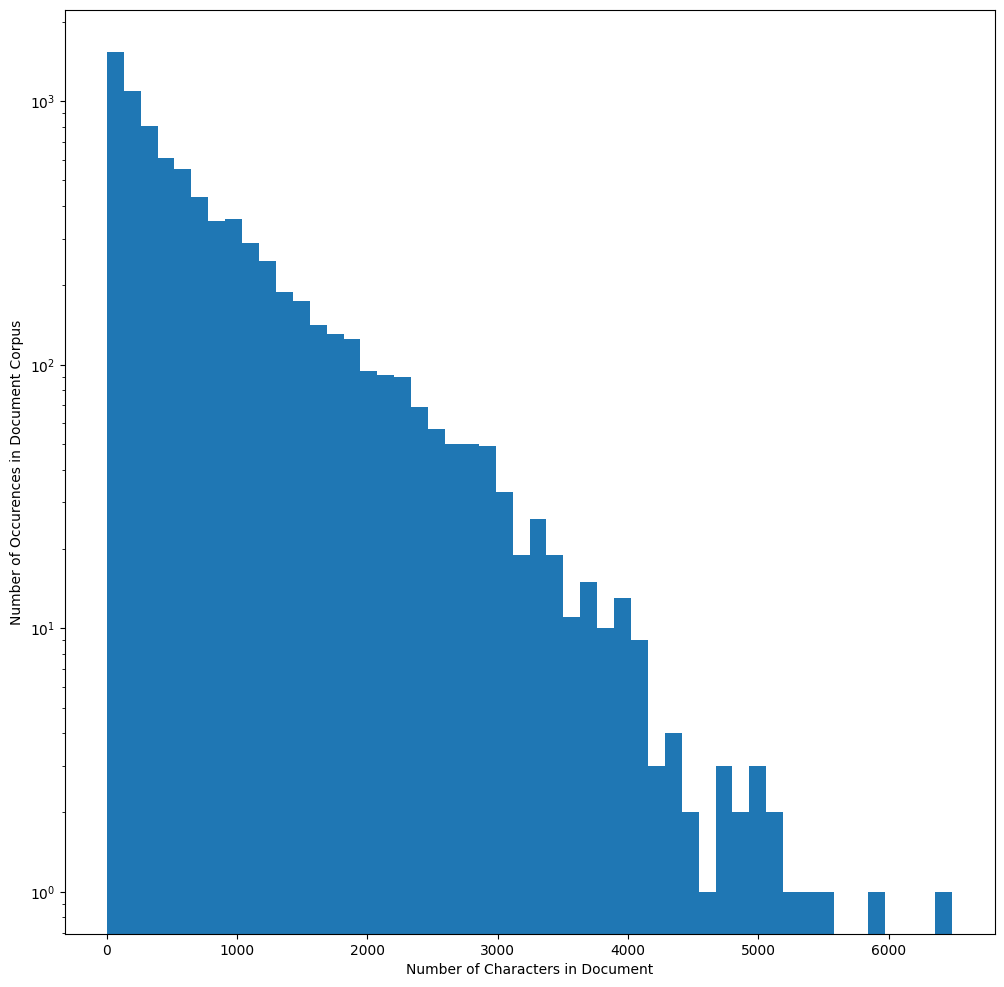

In [5]:
document_lengths = [len(row['raw_content']) for row in tqdm(force_llm_dataset_scrubbed['train'])]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.hist(document_lengths, bins=50)
ax.set_yscale("log")
ax.set_ylabel("Number of Occurences in Document Corpus")
ax.set_xlabel("Number of Characters in Document")
plt.show()

We can see that there are many orders of magnitude more short documents < 5000 characters long compared to documents that are longer. Some documents have more than 30000 characters! Something we may have to deal with later.  

### Estimating the proportions of languages

The guys at [Fabric]() also applied some machine learning to identify which language the documents were in.  Let us now look at which languages are present, how many documents are in each language and also how many documents each corpus contained

  0%|          | 0/7774 [00:00<?, ?it/s]

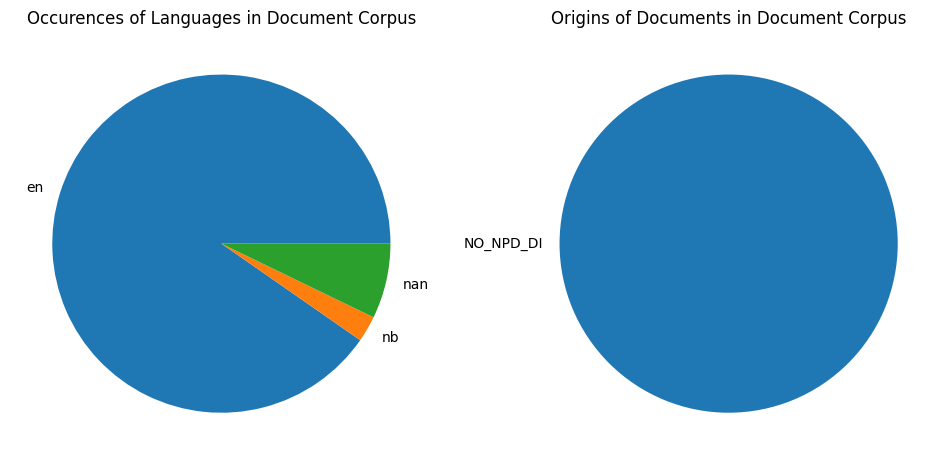

In [6]:
corpus_counter = Counter()
language_counter = Counter()
for row in tqdm(force_llm_dataset_scrubbed['train']):
    meta_dict = json.loads(row['meta'])
    language_counter.update([meta_dict['possible_lanaguage']])
    corpus_counter.update([meta_dict['corpus']])

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].set_title("Occurences of Languages in Document Corpus", fontsize=12)
ax[0].pie([val for _, val in language_counter.items()], labels=language_counter.keys())

ax[1].set_title("Origins of Documents in Document Corpus", fontsize=12)
ax[1].pie([val for _, val in corpus_counter.items()], labels=corpus_counter.keys())
plt.show()

Looks like most documents are likely in english, some norwegian bokmal (nb), soem dutch, and quite a few have a nan. The majority of documents seem to come from diskos (NO_NPD_DI). 

### Estimating word counts and creating a word-level dictionary

The first language model we will build is based on word-level representations.  

This means that we will need to know in some form what words we will consider as important or relevant.  By words we will understand a sequence of characters and possibly numbers e.g. a well name could be a word such as 16/10-2. 

To do this we will build a dictionary of the words in the documents.  

After estimating the frequency of each word we can truncate rare words that might not matter to us because they are so rare.  

Of course, technically, we should be careful at this point and make sure we keep words that are domain relevant.  

To be able to determine a dictionary we first need to split our documents which at this point are just sequences of characters into words. 

We will do some processing for each document and use a number of libraries to help us split into the right words. Nevertheless what we do here could be seen as quite crude. 

#### Defining a function to preprocess the documents and split them into words

We have used some of ChatGPTs ability to write regular expressions to clean some of the documents, and afterwards split documents using `nltk`s word tokenizer. 

In [7]:
def clean_text(text):
    """
    This function takes a string and removes non-sensical punctuation while trying to keep
    the punctuation that is part of technical terms or descriptions of equipment.

    Thanks ChatGPT - following prompt used:
    Can you give me some regex that will when preprocessing the following document remove all the punctuation that is non sensical but keep the one that is important for words or descriptions of equipment. We can also remove all occurrences of 

    Here the original text: INAM 350.41.04 12.0 Top Casingaok oorspr./beh. Tafel: —• 15 . 67 N.A.P. ..1 Onderstand: 8,25 fa. Top 20 'Bod. fl ens 'Casingsok. ../x in. N.A.P EINORAPPORT Terrein : Co evorden Prit No : 21 Loc. : YOV Samenvatting werkzaamheden Type boring: Appraisal Intallatie; 14  ..Montage. v.amaf: ,19 ; uur Coirdinaten: X= + Y. + Hoogte Kelderrand • +/x in NAP Toestand Werkdiepte: 3294 . 75 in. Top cement in link Casing( bs/ft, Gesleufd(...XGeperf.( mm; soh /m ) • ra. m. Aanv.Werkz heden: ,19802200 uur Einde Werkz.heden: 18/ 11,1980; „ 00 uur Einde Demontage: / 19 ; mr Aantal Boordagen/keparatiedagen: .Totaal..dapn. : 107 20 uur .. 80 Top Hanger/Packer/Gel , -trechter • 318 , 55 igalotaircxis (c 11 212,14 cateder ittecttc tax( it .flodem liner : 35.02-4.5.. geoementeerd , 3207,25 • Verbui zingen .2.8 'Stoye pipe Ingeheid tot ; 36 AmmatmxkW4x Driven in, ... MS/ft . : - rn. Top..c.ement. surf 13 3/8 lbs/ft, - in. lbs/ ft, ; - rn. Top cement: 1250 .S‘./C.B.L.) 9 5/8 it 535 lbsift,.. .L - 25.1.0.. ED in. 1.0.8 1.1.0M... —2789..2.. in. Top cement; m.(T.S.14(idx.i 53.5 Pile 7 casing 29 .._lbsift. I, .:.0 - .. ...lbsift, M. lbs/ft„ : - rn. 1 bs/ ft. In. . bb'id 01.1fadc..a,t,-) .long...length...f.ree Einddiepte: 3502.3.5... afgehangen aan Rats SRT - Head Tubingat 3283 Put afgewerkt met SRT Top cement in 4i/3i  iner st 3294, 75 B jgrncterheden:.. Ga gevuld met •Ca012. brine s.g. 4i kill string ingelaten 200 cement inside liner tot -1 m. above top liner hanger ± m. opgestaan met Dynadrill + Nowsco Coiled Oaaterking.en•.Head.,.get es.t .30.0 bar .. UREN SPECIFICAT1E Verh .km. boren kernen montage * demontage bei tel a/bodem round tr diversen k.a.a./bodem roundtrip Uren Totaal in. (eff. m.) ><X testen Schlumberger verbui z./cementeren plyggen zet ten productief maken vangwerk reparatie op onthoud tEinddr.uk • Jubing: ;. .Sarnenstelling • shoe + 352 jts + 11e117Nipple, total .Afgehangen..aan• SET 5000 head RAMS .Gravel pack: ..nun. Kg/czn2 liturbehandelincr  inoomodr.ukiSqueezerlruk• Katcrn2. Type producent: .P.roducti.ev.e..flormatie. ZEZ 2C + ZEZ 2C of Tot. (excl mint. demont. ) 100 ILL.; Fauveau frei • • Excl. Vdoracatags C, liasco-f

    Here the split tokenized example as you can see it currently keeps a bunch of punctuation which it shouldn't: ['INAM', '..', '.', 'Top', 'Casingaok', 'oorspr./beh', '.', 'Tafel', ':', '—•', '.', 'N.A.P', '.', '..', 'Onderstand', ':', ',', 'fa', '.', 'Top', "'Bod", '.', 'fl', 'ens', "'Casingsok", '.', '/x', 'in', '.', 'N.A.P', 'EINORAPPORT', 'Terrein', ':', 'Co', 'evorden', 'Prit', 'No', ':', 'Loc', '.', ':', 'YOV', 'Samenvatting', 'werkzaamheden', 'Type', 'boring', ':', 'Appraisal', 'Intallatie', ';', 'Montage', '.', 'v.amaf', ':', ',', ';', 'uur', 'Coirdinaten', ':', 'X=', '+', 'Y', '.', '+', 'Hoogte', 'Kelderrand', '•', '+/x', 'in', 'NAP', 'Toestand', 'Werkdiepte', ':', '.', 'in', '.', 'Top', 'cement', 'in', 'link', 'Casing', '(', 'bs/ft', ',', 'Gesleufd', '(', 'XGeperf', '.', '(', 'mm', ';', 'soh', '/m', ')', '•', 'ra', '.', 'm.', 'Aanv.Werkz', 'heden', ':', ',', 'uur', 'Einde', 'Werkz.heden', ':', '/', ',', ';', '„', 'uur', 'Einde', 'Demontage', ':', '/', ';', 'mr', 'Aantal', 'Boordagen/keparatiedagen', ':', '.Totaaldapn', '.', ':', 'uur', 'Top', 'Hanger/Packer/Gel', ',', '-trechter', '•', ',', 'igalotaircxis', '(', 'c', ',', 'cateder', 'ittecttc', 'tax', '(', 'it', '.flodem', 'liner', ':', '.-4', '...', 'geoementeerd', ',', ',', '•', 'Verbui', 'zingen', '..', "'Stoye", 'pipe', 'Ingeheid', 'tot', ';', 'AmmatmxkW4x', 'Driven', 'in', ',', 'MS/ft', '.', ':', '-', 'rn', '.', 'Topc.ement', '.', 'surf', '/8', 'lbs/ft', ',', '-', 'in', '.', 'lbs/', 'ft', ',', ';', '-', 'rn', '.', 'Top', 'cement', ':', '.S', '‘', './C.B.L', '.', ')', '/8', 'it', 'lbsift', ',', '.L', '-', '....', 'ED', 'in', '.', '..', '..', '0M', '—', '....', 'in', '.', 'Top', 'cement', ';', 'm.', '(', 'T.S', '.', '(', 'idx.i', '.', 'Pile', 'casing', '_lbsift', '.', 'I', ',', '.', ':', '.', '-', 'lbsift', ',', 'M.', 'lbs/ft', '„', ':', '-', 'rn', '.', 'bs/', 'ft', '.', 'In', '.', '.', "bb'id", '.1fadca', ',', 't', ',', '-', ')', '.longlengthf.ree', 'Einddiepte', ':', '...', 'afgehangen', 'aan', 'Rats', 'SRT', '-', 'Head', 'Tubingat', 'Put', 'afgewerkt', 'met', 'SRT', 'Top', 'cement', 'in', '4i/3i', 'iner', 'st', ',', 'B', 'jgrncterheden', ':', 'Ga', 'gevuld', 'met', '•Ca012', '.', 'brine', 's.g.', '4i', 'kill', 'string', 'ingelaten', 'cement', 'inside', 'liner', 'tot', '-', 'm.', 'above', 'top', 'liner', 'hanger', '±', 'm.', 'opgestaan', 'met', 'Dynadrill', '+', 'Nowsco', 'Coiled', 'Oaaterking.en•.Head.', ',', '.get', 'es.t', '..', 'bar', 'UREN', 'SPECIFICAT1E', 'Verh', '.km', '.', 'boren', 'kernen', 'montage', '*', 'demontage', 'bei', 'tel', 'a/bodem', 'round', 'tr', 'diversen', 'k.a.a./bodem', 'roundtrip', 'Uren', 'Totaal', 'in', '.', '(', 'eff', '.', 'm.', ')', '>', '<', 'X', 'testen', 'Schlumberger', 'verbui', 'z./cementeren', 'plyggen', 'zet', 'ten', 'productief', 'maken', 'vangwerk', 'reparatie', 'op', 'onthoud', 'tEinddr.uk', '•', 'Jubing', ':', ';', '.', '.Sarnenstelling', '•', 'shoe', '+', 'jts', '+', '11e117Nipple', ',', 'total', '.Afgehangenaan•', 'SET', 'head', 'RAMS', '.Gravel', 'pack', ':', 'nun', '.', 'Kg/czn2', 'liturbehandelincr', 'inoomodr.ukiSqueezerlruk•', 'Katcrn2', '.', 'Type', 'producent', ':', '.P.roducti.ev.eflormatie', '.', 'ZEZ', '2C', '+', 'ZEZ', '2C', 'of', 'Tot', '.', '(', 'excl', 'mint', '.', 'demont', '.', ')', 'ILL.', ';', 'Fauveau', 'frei', '•', '•', 'Excl', '.', 'Vdoracatags', 'C', ',', 'liasco-f']
    """
    
    # Regex to remove non-sensical punctuation
    regex_pattern = r"(?<!\d)[.,;:!?](?!\d)|(?<=\s)[-/](?=\s)|(?<=[a-zA-Z])[/](?=\s)"
    
    # Replace the matched characters with an empty string
    cleaned_text = re.sub(regex_pattern, '', text)
    
    return cleaned_text

def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r'(?<!\d)[.-]{2,}(?!\d)', '', text)
    
    text = clean_text(text)
    
    # Tokenize text
    words = word_tokenize(text)

    return words

for row in force_llm_dataset_scrubbed['train']:
    print(row['raw_content'])
    print(preprocess(row['raw_content']))
    break

5.6.1 RM_StethoScope_Run3_Test6 5.6.1.1 Pressure vs. Time Plot Run No:3 Test No:6 Probe MD:12832.22ft Probe TVD:10180.65ft Mud Before(6463.698psi) Inv. Start Draw Down(6462.766psi) Inv. Start Build Up(6297.74psi) ^ Inv. End Build Up(6380.823psi) ^ Final Start Draw Down(6380.823psi) Final Start Build Up(6101.92psi) Final End Build Up(6460.895psi) Mud After(6459.887psi) Tool Type: StethoScope Pretest Type: Type 0-B Pretest Status: Lost Seal Primary Gauge: AQAP Probe Orientation: 150 (deg) Formation Pressure: Pressure Variance (psi) 60s Slope (psi/min) Quality Indicator Bad test: Lost seal 2010-11-11 30
['5.6.1', 'rm_stethoscope_run3_test6', '5.6.1.1', 'pressure', 'vs', 'time', 'plot', 'run', 'no:3', 'test', 'no:6', 'probe', 'md:12832.22ft', 'probe', 'tvd:10180.65ft', 'mud', 'before', '(', '6463.698psi', ')', 'inv', 'start', 'draw', 'down', '(', '6462.766psi', ')', 'inv', 'start', 'build', 'up', '(', '6297.74psi', ')', '^', 'inv', 'end', 'build', 'up', '(', '6380.823psi', ')', '^', 'final

We can see from the above that some of the documents are hard to read and also have weird words and symbols. We would definitely want to improve this but let us move on!

#### Counting the number of occurences of unique words in our documents

Let us use a Counter object to count the unique words. This data structure is a bit like a set in the way that it considers only unique words and in addition also keeps track of the number of times we have added these words to the `Counter`.

In [8]:
# Create a counter to count word tokens
word_freq = Counter()
for row in tqdm(force_llm_dataset_scrubbed['train']):
    words = preprocess(row['raw_content'])
    word_freq.update(words)

  0%|          | 0/7774 [00:00<?, ?it/s]

Let's look at the top 100 most frequent words. 

In [9]:
dict(word_freq.most_common(30))

{'the': 28167,
 ')': 20914,
 '(': 20337,
 'to': 16361,
 'and': 15580,
 'of': 14160,
 'in': 11027,
 'with': 5294,
 'well': 5196,
 'at': 5037,
 'is': 4948,
 'from': 4758,
 '[': 4558,
 ']': 4470,
 'pressure': 4458,
 'was': 4442,
 '%': 4340,
 'on': 4276,
 'no': 4166,
 'for': 4072,
 "'": 4069,
 '*': 3526,
 'hole': 3517,
 '.': 3216,
 'depth': 3124,
 ',': 3026,
 'be': 3017,
 'by': 2871,
 '1': 2834,
 'time': 2675}

We can see that many so-called `stop-words` are amongst the most frequent words like `the`or `and`, but also domain words like `well`or `depth` seem to be extremely common!

#### Creating the dictionary of words for the dataset

We're gonna make our life a little bit easier and only keep words that have at least 500 occurences. The reason for this is that very large dictionaries may require very large neural network layers and we want things to be computationally maneagble. In this case we are willing to sacrifice fidelity for the sake of clarity and ease of use. 

In [10]:
# We will only consider words that have 100 or more occurences. 
common_words = {word for word, freq in word_freq.items() if freq >= 500}
word_dict = {word: idx for idx, (word, _) in enumerate(word_freq.most_common()) if word in common_words}

Let's look at the final word dictionary

In [11]:
print(f"Number of words in dictionary: {len(word_dict)}")
print({word: key for idx, (word, key) in enumerate(word_dict.items()) if idx < 100})

Number of words in dictionary: 268
{'the': 0, ')': 1, '(': 2, 'to': 3, 'and': 4, 'of': 5, 'in': 6, 'with': 7, 'well': 8, 'at': 9, 'is': 10, 'from': 11, '[': 12, ']': 13, 'pressure': 14, 'was': 15, '%': 16, 'on': 17, 'no': 18, 'for': 19, "'": 20, '*': 21, 'hole': 22, '.': 23, 'depth': 24, ',': 25, 'be': 26, 'by': 27, '1': 28, 'time': 29, 'md': 30, 'are': 31, 'mud': 32, 'this': 33, 'as': 34, 'data': 35, 'run': 36, 'm': 37, 'sponge': 38, 'drilling': 39, 'report': 40, 'section': 41, 'up': 42, 'date': 43, '10': 44, 'test': 45, 'core': 46, '3': 47, 'i': 48, 'were': 49, 'temperature': 50, 'page': 51, '2': 52, 'calibration': 53, '#': 54, 'a': 55, ':': 56, 'it': 57, '=': 58, 'water': 59, '&': 60, 'gas': 61, 'formation': 62, 'sample': 63, 'oil': 64, 'total': 65, 'type': 66, 'out': 67, 'bar': 68, '0': 69, 'most': 70, 'casing': 71, 'rig': 72, 'tr': 73, 'bit': 74, 'or': 75, '4': 76, '20': 77, 'not': 78, 'drill': 79, '12': 80, 'tool': 81, 'tvd': 82, 'gauge': 83, 'that': 84, '1/2': 85, '+': 86, 'down

The above is part of our dictionary. Every word has a unique number by which we will represent the words and make them amenable for a machine learning task. 

The sentence `cement the well` would then become `[70, 0, 11]` using our dictionary. 

#### Writing and Reading the word dict from disk (faster)

In [19]:
# if not LOAD_FROM_DISK:
#     with open('../data/word_freq_scrubbed.json', 'w') as json_file:
#         json.dump(word_freq, json_file, indent=4)
    
#     with open('../data/word_dict_scrubbed.json', 'w') as json_file:
#         json.dump(word_dict, json_file, indent=4)

# if LOAD_FROM_DISK:
#     # Read the file and convert the JSON content to a Python dictionary
#     with open('../data/word_freq_scrubbed.json', 'r') as json_file:
#         word_freq = json.load(json_file)
#         word_freq = Counter(word_freq)
    
#     with open('../data/word_dict_scrubbed.json', 'r') as json_file:
#         word_dict = json.load(json_file)

idx_word_map = {item: key for key, item in word_dict.items()}

## Continuous Bag of Words - Creating Word Level Embeddings

Now let us turn to our first natural language task: creating word-level representations for natural language processing tasks. The obtained representations are continuous vectors for each word - one vector per word in our dictionary.

Why might we care about these vector representations?  

- We can learn something about the relationships between words - clustering. 
- We can use the representations for supervised learning tasks such as classification.

The [Continuous Bag of Words Model - CBOW]() is an unsupervised approach to learning word-level representations. 

The model has a very simple structure. We will consider a fixed window left and right of a given word. Base on the words in these context windows we will try to predict what the middle word is. 

In a probabilistic sense our model tries to represent $p(w_i|w_{i+2}, w_{i+1}, w_{i-1}, w_{i-2})$. We do this by fitting a model with parameters $\mathbf{\theta}$ from data by finding a maximum likelihood solution by minimizing the negative log-likelihood using gradient descent. 

The model we will create to represent the distribution $p_{\mathbf{\theta}}(w_i|w_{i+2}, w_{i+1}, w_{i-1}, w_{i-2})$ is a neural network with two hidden layers and an embedding layer. 

Embedding layers are a different representation of a simple input layer. Instead of one-hotting the input vector we can provide the indexes from our dictionary and the embedding layer will retrieve a unique trainable vector of parameters from our embedding layer. 

These embedding vectors are unique to each word and will be the ones that we later use to represent our words in our texts. 

### Imports and helpers

We have a couple of inputs we need to take care of as well as some helper function to set the random seed and make the workflow reproducible. 

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from itertools import chain, islice
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random
import os
from IPython.display import display
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

def set_seed(seed):
    """Set the random seed for reproducibility."""
    # Python random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Configure PyTorch to be deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Change the device here e.g. cpu or cuda depending on what you want to use to run
device = "cuda"

### Creating a CBOW dataset generator

We will first need to make a generator for our dataset. 

Here we can parameterize by the size of the context window on each side of the word in the middle, as well as wether we want different number of words on each side.  

There's been some later work that did this e.g. for [word2vec](). 

The example use at the end shows how to create our batches for training our model. 

In [14]:
def make_cbow_context(tokenized, window_size=2, deterministic=False):
    # Create context windows using islice for elegant slicing
    for idx in range(window_size, len(tokenized) - window_size):
        ws = np.random.randint(1, window_size) if not deterministic else window_size
        historical = islice(tokenized, idx - ws, idx)
        
        ws = np.random.randint(1, window_size) if not deterministic else window_size
        future = islice(tokenized, idx+1, idx+1 + ws)
        yield list(chain(historical, future)), tokenized[idx]

def pad_sequence(seq, pad_value, max_length):
    # Pad sequence to the required length
    return np.pad(seq, (0, max_length - len(seq)), constant_values=pad_value)

def get_batch(dataset, word_dict, batch_size=32, window_size=2, deterministic=False):
    # Using generator expression for batch creation
    batch_x = []
    batch_y = []
    for row in dataset:
        tokenized = [word_dict.get(word) for word in preprocess(row['raw_content']) if word in word_dict]
        for cbow, target in make_cbow_context(tokenized, window_size=window_size, deterministic=deterministic):
            batch_x.append(cbow)
            batch_y.append(target)
            if len(batch_x) == batch_size:
                max_length = window_size * 2
                
                # Create padded batch and yield
                padded_x = [pad_sequence(x, len(word_dict), max_length) for x in batch_x]
                mask = np.not_equal(padded_x, len(word_dict))
                yield padded_x, batch_y, mask
                batch_x, batch_y = [], []  # Reset the batches

# Let us test this out and create some batches of data
shuffled_dataset = force_llm_dataset_scrubbed['train'].shuffle(seed=42)

# Main loop to process batches
for i, (X, y, mask) in enumerate(get_batch(shuffled_dataset, word_dict, batch_size=4, window_size=2, deterministic=True)):
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    mask = torch.tensor(mask, dtype=torch.long)
    print(X, y, mask)
    break

tensor([[  0,  10,   0,   9],
        [ 10,   5,   9,  71],
        [  5,   0,  71, 182],
        [  0,   9, 182, 181]]) tensor([ 5,  0,  9, 71]) tensor([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]])


C:\Users\tibarii\AppData\Local\Temp\ipykernel_22228\1970702572.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  X = torch.tensor(X, dtype=torch.long)


We return here `X` which contains the tokenized word context windows, `y` the token of the middle word to be predicted, and a mask in case we have batches with different context lengths so we can average over the right number of vectors in our model.  

Notice also that we introduce an `<empty>` token to pad any sequences that are not the same length but let us create nice batches of data for efficient training. 

### Implementing the Continuous Bag of Words model for word-level embeddings

Here we now implement the CBOW neural network model. 

Technically this is a deep neural network with an input layer `self.embedding`,  2 hidden layers, `self.linear1` and `self.linear2` all together with a `ReLU` activation function. 

The final output also has a `log_softmax` activation which normalizes the outputs to be between 0 and 1, which means we are predicting the log-probabilities over each word in our word dictionary. 

A word about our embedding layer. `torch.nn.Embedding` is a special layer as it takes as an input an index and returns a numerical vector with sizer `d_embedding`. This way we don't have to perform any one-hot encoding. The one-hot encoded vector would be extremely sparse i.e. just one digit 1 in a vector of 100s of thousands of words. Kind of inefficient. So this does away nicely. 

We also include our `<stop>` token here so that it gets embedded, but we use a masked sum operation to make sure we don't add its value to the overall sum when computing the intermediate representations for batches with different number of elements in their input sequence. 

In [15]:
class CBOW(nn.Module):
    def __init__(self, padding_idx, d_embedding: int = 128, n_vocab: int = 10, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=d_embedding, padding_idx=padding_idx)
        self.linear1 = nn.Linear(d_embedding, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, n_vocab)
        self.activation = nn.ReLU()
    def embed(self, x):
        return self.embedding(x)
    
    def forward(self, x, mask):
        embedded = self.embedding(x)  # Get the embeddings for x
        mask = mask.unsqueeze(-1)     # Add a dimension for broadcasting
        masked_embedded = embedded * mask  # Apply the mask
        sum_embeddings = masked_embedded.sum(dim=1)  # Sum only the masked (valid) embeddings
        hidden_1 = self.activation(self.linear1(sum_embeddings))
        log_probs = F.log_softmax(self.linear2(hidden_1), dim=1)
        return log_probs

### Some helper functions to compute word embeddings for a given word

We will use the following to make nice representations during training to see how the relationships between a word we know is in the corpus and its nearest neighbors. 

In [16]:
def set_styling(df):
    # Assuming your DataFrame 'df' is already created
    # Apply some basic styling to the DataFrame
    styled_df = df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'),
                    ('text-align', 'center'),
                    ('background-color', 'lightgrey'),
                    ('color', 'black')]},
         {'selector': 'td',
          'props': [('text-align', 'center'),
                    ('background-color', 'white'),
                    ('color', 'black'),
                    ('font-size', '10pt')]}
        ]
    ).set_properties(**{'margin': '0 auto'})#.hide_index()
    return styled_df
    
def check_embeddings(model, word):
    word_idx = word_dict[word]
    with torch.no_grad():
        word_vec = model.embedding.weight[word_idx]
        cos = F.cosine_similarity(word_vec.unsqueeze(0), model.embedding.weight, dim=1)
        argsort = torch.argsort(cos, descending=True)
        nearest_neighbors = [idx_word_map[idx.item()] for idx in argsort 
                             if idx != word_idx and idx != len(word_dict)][:10]
        return nearest_neighbors

def get_table_of_nearest_neighbors(model, words_to_validate):
    neighbors_dict = {}
    for word in words_to_validate:
        neighbors_dict[word] = check_embeddings(model, word)

    # Convert the dictionary to a pandas DataFrame for nice tabular display
    df = pd.DataFrame(neighbors_dict.items(), columns=['Word', 'Nearest Neighbors'])
    df.set_index('Word', inplace=True)
    return df

### Training the Continuous Bag of Words Model

Let us now train the continuous bag of words model.  

We shuffle and split the dataset into two parts - train and validation. 

After we instantiate the model and the optimizer, in this case AdamW is used, 
we iterate over batches of data and train the model. 

At every iteration we compute the mismatch, the gradient of the loss with respect to the parameters of the model and perform one step of stop gradient descent optimization. 

We plot the train and validation losses during training and also show what the nearest neighbors of the word `well` are. 

7766 8


0it [00:00, ?it/s]

0it [00:00, ?it/s]

[0.0] [0]


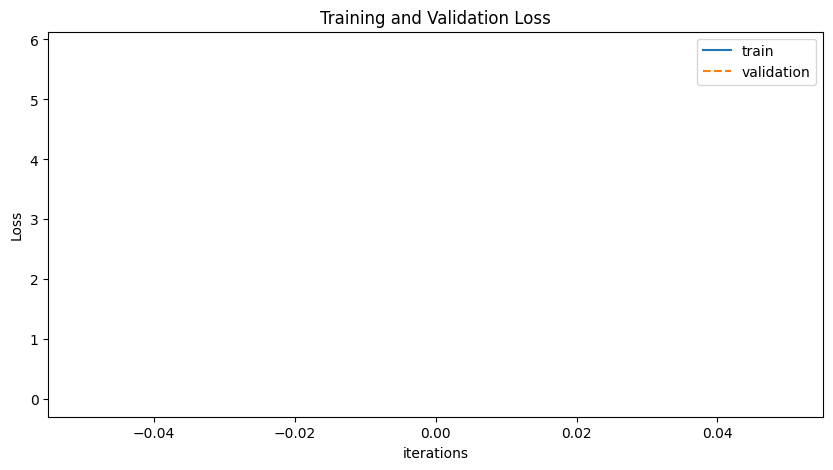

In [36]:
words_to_validate = ["oil"]

# Define the validate function
def validate(model, valid_dataset, loss_function, word_dict):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No gradients required for validation
        for X_val, y_val, mask_val in tqdm(get_batch(valid_dataset, word_dict, batch_size=256, window_size=2, deterministic=True)):
            X_val = torch.tensor(X_val).to(device)
            y_val = torch.tensor(y_val).to(device)
            mask_val = torch.tensor(mask_val).to(device)
            log_probs_val = model(X_val, mask_val)
            loss = loss_function(log_probs_val, y_val)
            total_loss += loss.item()
    return total_loss / len(valid_dataset)


# Shuffle the dataset
shuffled_dataset = force_llm_dataset_scrubbed.shuffle(seed=42)['train']

# Slice the dataset to create training and validation sets
train_dataset = shuffled_dataset.select(range(int(0.999 * len(shuffled_dataset)))).shuffle(seed=69)
valid_dataset = shuffled_dataset.select(range(int(0.999 * len(shuffled_dataset)), len(shuffled_dataset))).shuffle(seed=420)

print(len(train_dataset), len(valid_dataset))

loss_function = nn.NLLLoss()
model = CBOW(len(word_dict.keys()), 128, len(word_dict.keys())+1, hidden_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Initialize lists to store loss values for plotting
train_losses = []
valid_losses = []
valid_iterations = []

# Training loop
prog_bar = tqdm(get_batch(train_dataset, word_dict, batch_size=256, window_size=2, deterministic=True))
for i, (X, y, mask) in enumerate(prog_bar):
    X = torch.tensor(X).to(device)
    y = torch.tensor(y).to(device)
    mask = torch.tensor(mask).to(device)
    
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    log_probs = model(X, mask)
    loss = loss_function(log_probs, y)
    loss.backward()
    optimizer.step()
    prog_bar.set_description_str(f"Loss: {loss.item()}")
    train_losses.append(loss.item())
    
    # Inside your training loop
    if i % 50000 == 0:
        val_loss = validate(model, valid_dataset, loss_function, word_dict)
        valid_losses.append(val_loss)
        valid_iterations.append(i)
        print(valid_losses, valid_iterations)
        # Plotting without pausing the execution
        plt.figure(figsize=(10,5))
        plt.title("Training and Validation Loss")
        plt.plot(range(i+1), train_losses, label="train")  # Update x-axis for training loss
        plt.plot(valid_iterations, valid_losses, label="validation", linestyle='--')  # Plot validation loss against iteration
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.draw()
        plt.pause(0.001)  # Pause briefly to allow the plot to be displayed
        
        # Free up memory after the plot is drawn
        plt.close()

        df = get_table_of_nearest_neighbors(model, words_to_validate)
        df = set_styling(df)
        display(df)

We can see that in the beginning of training the nearest neighbors are unrelated words to the word `well` but at the end we get meaningful nearest neighbors. 

### Saving the model weights

In [37]:
print(os.getcwd())

d:\projets\force_npd_llm_hackathon\notebooks


In [38]:

torch.save(model.state_dict(), "../data/cbow_10112023.pth")

### Load the model weights

In [39]:
if LOAD_FROM_DISK:
    model = CBOW(len(word_dict.keys()), 128, len(word_dict.keys())+1, hidden_dim=128).to(device)
    model.load_state_dict(torch.load("../data/cbow_10112023.pth"))

### Plotting the word embeddings in a lower dimensional space

We can also plot the embeddings we produce in a two-dimensional space using a dimensionality reduction technique like PCA or TSNE. 

Here we used the latter to show where the different words end up in the embedding space. 

In [40]:
# For demonstration, let's create a smaller synthetic dataset
X = model.embedding.weight.detach().cpu().numpy()[:-1]
labels = word_dict.keys()
labels = [str(label) for label in labels]  # Convert numerical labels to strings for visualization

# Run t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 268 samples in 0.002s...
[t-SNE] Computed neighbors for 268 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 268 / 268
[t-SNE] Mean sigma: 3.454615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.674522
[t-SNE] KL divergence after 500 iterations: 1.408571


In [41]:
from cluestar import plot_text

plot_text(X_tsne, labels, color_words=["well", "pore", "rock", "subsurface", "geoscience", "hordaland"])

alt.HConcatChart(...)

Hovering over some of the clusters above we can see that some related words or numbers group up in the right place. This indicates that for a task where we try to for example classify domain related words we might be able to use these embeddings in a supervised or unsupervised learning task. 

## Going from words to sentences

We have done quite a bit now already with individual words, but really words are only part of a story. Let us move towards sentence representations. 

These can be really useful when we try to find similar documents in our million document corpus for example. 

A first step one can try is to use pre-trained embeddings. Whether open-source or from an API endpoint it is often good to try an existing model to validate if it is necessary to potentially train our own. 

More on that later. 

Let us now use the [Azure OpenAI API]() to compute embeddings for some of our documents, and subsequently how we might use such sentence or document-level embeddings. 

### Imports 

In [3]:
from openai import AzureOpenAI
from openai.types import Embedding
from dotenv import load_dotenv
import pytest
import os
import logging
import tiktoken 
from json import JSONDecodeError
from sklearn.metrics.pairwise import cosine_similarity
from cluestar import plot_text

### Using a pre-trained embeddings model to cluster and retrieve text passages: OpenAI embedding-ada-002

We will use the `openai` library to compute embeddings.  
For this we have created two `.env` files: `.env.secret` and `.env.shared` 

The former contains the API key which you will receive from the hackathon facilitators. The latter contains the configuration for all the deployed models and their endpoints.  

In [4]:
# Load the shared environment variables, not secrets
load_dotenv("../.env.shared")
load_dotenv("../.env.secret")

openai_client = AzureOpenAI(
    api_version=os.environ["OPENAI_API_VERSION"],
    azure_endpoint=os.environ["OPENAI_API_BASE"],
    api_key=os.environ["OPENAI_API_KEY"]
)

embedding = openai_client.embeddings.create(input=["sample text", "other sample text"], 
                                    model=os.environ["ADA002_DEPLOYMENT"])

print(len(embedding.data[0].embedding))

1536


Compared to our word-level embedding this is a pretty big vector space!

### Embedding 1000 Sentences using the Ada-002 model

Let us grab 1000 sentences from our scrubbed dataset and compute the embeddings.  
This small dataset of embeddings and sentences will allow us to explore what we can use these embeddings for, and what quality the embedding space has for a domain-specific dataset like ours. 

In [ ]:
enc = tiktoken.get_encoding("cl100k_base")
sentences, sentence_embeddings_ada = [], []
for idx, row in enumerate(tqdm(force_llm_dataset_scrubbed['train'])):
    if len(enc.encode(row['raw_content'])) < 8000:
        embedding = openai_client.embeddings.create(input=[row['raw_content']], 
                                    model=os.environ["ADA002_DEPLOYMENT"])
        sentences.append(row['raw_content'])
        sentence_embeddings_ada.append(np.array(embedding.data[0].embedding))
    if idx == 1000:
        break

### Saving the embeddings to disk

In [ ]:
if not LOAD_FROM_DISK:
    with open('../data/sentences.json', 'w') as json_file:
            json.dump({"sentences": sentences}, json_file, indent=4)
    
    with open('../data/sentences_embeddings.json', 'w') as json_file:
            json.dump({"sentences_embeddings": [list(emb) for emb in sentence_embeddings_ada]}, json_file, indent=4)

if LOAD_FROM_DISK:
    with open('../data/sentences.json', 'r') as json_file:
        sentences = json.load(json_file)["sentences"]

    with open('../data/sentences_embeddings.json', 'r') as json_file:
        sentence_embeddings_ada = json.load(json_file)["sentences_embeddings"]
        sentence_embeddings_ada = np.array(sentence_embeddings_ada)

### Computing and displaying embeddings of the sentences

Again we compute a t-SNE representation of the sentences so we can see how different sentences cluster together. We have highlighted sentences that contain specific words to see how they are spread across the embedding space. 

In [ ]:
# Run t-SNE
tsne_ada  = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_ada = np.array(sentence_embeddings_ada)
X_tsne_ada = tsne_ada .fit_transform(X_ada)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1001 samples in 0.001s...
[t-SNE] Computed neighbors for 1001 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1001
[t-SNE] Computed conditional probabilities for sample 1001 / 1001
[t-SNE] Mean sigma: 0.172059


/Users/lmoss/Documents/GitHub/force_npd_llm_hackathon/venv/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.742920
[t-SNE] KL divergence after 500 iterations: 0.967614


In [ ]:
plot_text(X_tsne_ada, sentences, color_words=["well", "geological"])

alt.HConcatChart(...)

From the embedding space we can see for example that some of the dutch sentences cluster together or that sentences that talk about claystone and sandstone seem to be close in embedding space. Not bad at all!

### Can we use these out of the box for retrieval?

One common task that has recently gained alot of interest is [information retrieval or IR]() and [retrieval augemented generation or RAG](). 

Information retrieval is extracting or retrieving information from large sets of unstructured or structured data. Ultimately trying to find relevant information for a given query. An example of this might be trying to find all the relevant reports that mention work related incidents. Good retrieval systems would find all relevant articles and maybe even rank them according to relevance. 

One simple way to achieve a very basic form of retrieval is using embeddings of both queries or questions and a large set of questions and finding the most similar embeddings from the corpus according to some metric. 

One such metric is the cosine similarty or angle between two high-dimensional vectors. 

High-dimensional spaces are a weird place where alot of intuitions go out the window and I highly recommend reading up on [the curse of dimensionalty] to understand why. 

In this case we will mostly pretend as if we knew what high-dimensional spaces look like and do like everyone else and imagine a 3D space (with some added pitfalls). 

In the following we compute and embedding for a given question and then measure the cosine similarity between the question-embedding-vector and all sentence-embedding-vectors. 

We then rank the sentences in decreasing cosing similarity coefficient and see which documents show up. 

In [ ]:
# Let's first embed the question
embedded_question = openai_client.embeddings.create(input=["I'm looking for examples of End of Well Reports from Vermillion Energy?"], 
                                    model=os.environ["ADA002_DEPLOYMENT"])
embedded_question = np.array(embedded_question.data[0].embedding).reshape(1, -1)

sentence_embeddings_ada_np = np.array(sentence_embeddings_ada)

print(sentence_embeddings_ada_np.shape)


cosines = cosine_similarity(embedded_question, sentence_embeddings_ada_np)
sorted_sentences = [sentences[idx] for idx in np.argsort(cosines)[0][::-1]]
sorted_sentences_df = pd.DataFrame({"most similar sentences in corpus": sorted_sentences[:5]})

sorted_sentences_df = set_styling(sorted_sentences_df)
display(sorted_sentences_df)

(1001, 1536)


We can see that exactly the documents that talk about what was in the question show up in this case. Great! So, do we even need our own embeddings? Could we do better? How do we measure this on average? Can we make some datasets for this? Questions you may be able to find answers for. 

For now let us assume we did want to train our own sentence embedding model. How would we go about it?

## Overcoming the cold-start problem: GPT4 to the Rescue

In our case, we will train a sentence_transformer on the task of [natural language inference](). This task can take on many forms but in essence we can train a model to predict the similarity between pairs of sentences. 

For this we would need a dataset of the following form:
`Sentence A`, `Sentence B`, `Similarity Score`

We have a huge corpus of information but we don't have any dataset like this. 

What could we do to help ourselves out?

This is where the power of generalist LLMs like GPT4 really shines. 

Instead of spending hours and hours annotating our own dataset (what we should really be doing) we're gonna bootstrap a dataset using GPT4, an incredibly powerful LLM from OpenAI to bootstrap a dataset for us. 

Models like GPT4 are trained based on instruction tuning, and are adapted to follow instructions by the user without retraining them on a given dataset. Sometimes it does help to provide some examples of what you would like the LLM to do. This is called in-context learning, either zero-shot (without examples) or few-shot (with a few examples of the task solution in our prompt). 

If we can craft a prompt that will extract examples of these kinds of dataset for us well, then maybe we can create a dataset that's good enough to train our own model. 

There's a caveat though - calling this model is expensive - really expensive. So we will not be able to get that many examples, but a few thousand we can compute for reasonable cost. 

Let us see if that works out. 

### Prompt Engineering a paired dataset generator

In the following we have created a prompt that describes the task that we want GPT4 to perform. We will give it two long form documents and it should extract a JSON representation of pairs of sentences and a provided score for each pair. 

Sometimes the JSON structure doesn't parse, and sometimes the profanity filter kicks in - so we have to deal with that through exception handling. But it turns out we can get a noisy but hopefully useful dataset with this technique. 

We have precomputed examples that can be shared, but here's how you can do it. 

Note that this prompt was made in a few minutes - we can certainly improve here or reduce cost by using other cheaper models.

In [ ]:
system_prompt = """The user will provide you with a simple statement of FIRST and SECOND which contains two texts.

FIRST: 

SECOND: 

The documents can be in different languages. They all come from the same domain of oil and gas exploration and production. 

You will extract sentences from FIRST and SECOND that follow the text closely from both pieces of text.
The sentence pairs should always consist of two different sentences from the text. 
You may also use exact sentences or shorten the sentences to phrases to generate examples.
You may paraphrase the content in sentences or change them slightly but you must preserve both language and style of individual texts.
If there are no examples to generate then create an empty list. 

Each pair of sentences a SCORE. The SCORE should be based on how semantic similar the two sentences are.

Be HIGHLY attentive to the semantic similarities not necessarily the syntactic similarities. 
Two statements in two different languages with the same meaning can be considered similar.

Sentence pairs that are semantic different should receive scores ranged to 0.0 to 0.2. 
Sentence pairs with some semantic differences should receive scores ranged 0.2 to 0.8.
Sentence pairs with strong semantic similarities should receive scores in the range from 0.8 to 1.0.

Just because two sentences have numbers does not make them similar. If they are different them make them 0.0. 
But if you see similarities in content then dont make them 0.0 choose higher values as you see fit. 

You are to produce a JSON formatted output, with JSON output only in the following form:

[{"1": "<Sentence 1a>", "2": "<Sentence 1b>", "SCORE": <Similarity of 1a and 1b as a number between 0 and 1>}, 
 {"1": "<Sentence 2a>", "2": "<Sentence 2b>", "SCORE": <Similarity of 2a and 2b as a number between 0 and 1>},
 ...,
 {"1": "<Sentence Na>", "2": "<Sentence Nb>", "SCORE": <Similarity of Na and Nb as a number between 0 and 1>}]

Make sure to always include the SCORE
You are to determine yourself how many examples N you can come up with. Just make sure its always JSON formatted.
"""

user_prompt = lambda a, b: """
FIRST: """+a+""" 

SECOND: """+b 


### Using GPT4 on Azure OpenAI to create paired rated sentences from prompt template

In [ ]:
# Load the shared environment variables, not secrets
load_dotenv("../.env.shared")
load_dotenv("../.env.secret")


openai_client = AzureOpenAI(
    api_version=os.environ["OPENAI_API_VERSION"],
    azure_endpoint=os.environ["OPENAI_API_BASE"],
    api_key=os.environ["OPENAI_API_KEY"]
)

text_1 = force_llm_dataset_scrubbed["train"][420]["raw_content"]
text_2 = force_llm_dataset_scrubbed["train"][69]["raw_content"]

completion = openai_client.chat.completions.create(model=os.environ["GPT432k_DEPLOYMENT"], 
                                            messages=[{"role": "system", 
                                                       "content": system_prompt}, 
                                                       {"role": "user", "content": user_prompt(text_1, text_2)}])


NameError: name 'load_dotenv' is not defined

### Let's validate our prompt engineering and see what the output looks like

Below we can see a parsed example of what GPT extracted from a set of documents. Most of the xamples shown here have a fairly low score as it seems the documents are really unrelated. 

In [ ]:
json.loads(completion.choices[0].message.content.strip())

[{'1': 'Continued to RIH and displaced to 10.3ppg OBM.',
  '2': 'LOCALLY ABUNDANT PANT REMAINS, SLIGHTLY GLAUCONITIC.',
  'SCORE': 0.1},
 {'1': 'Tagged bottom, broke in Bit and drilled 12 1/4 hole from 3070 to 3113 m.',
  '2': 'POOR TO MODERATELY SORTED, SUBANGULAR TO ROUNDED, SUBSPHERICAL, ABUNDANT SHELL FRAGMENTS.',
  'SCORE': 0.15},
 {'1': 'Flow Checked and POOH from 3160 to 1781 (normal drag).',
  '2': 'LIGHT TO MEDIUM GREENISH GREY TO LIGHT BROWNISH GREY, SOFT, AMORPHOUS, SWELLING, SILTY, SANDY.',
  'SCORE': 0.2},
 {'1': 'Continued to drill 12 1/4 hole from 3113 to 3160 m.',
  '2': 'FINE TO MEDIUM, LOCALLY VERY FINE AND COARSE, LIGHT BROWN, YELLOWISH ORANGE.',
  'SCORE': 0.3},
 {'1': 'Drilled 12 1/4 hole from 3070 to 3113 m.',
  '2': 'LIMESTONE: OFF WHITE TO LIGHT GREY, SOFT TO PREDOMINANTLY FIRM, BLOCKY, CRUMBLY, ARGILLACEOUS.',
  'SCORE': 0.1},
 {'1': 'RIH from 1781 to 3160 and continued to drill 12 1/4 hole from 3160 to 3165 m.',
  '2': 'LIGHT TO MEDIUM GREY TO LIGHTISH BROWN G

### GPT4 go brrrrr: Generating a corpus of bootstrapped training data

In [ ]:
texts = []
total_pairs = 0
input_tokens, completion_tokens = 0, 0
prg_bar = tqdm(range(10000))
for idx in prg_bar:

    idx1 = np.random.randint(0, len(force_llm_dataset_scrubbed['train']))
    idx2 = np.random.randint(0, len(force_llm_dataset_scrubbed['train']))
    
    text_1_row = force_llm_dataset_scrubbed['train'][idx1]
    text_2_row = force_llm_dataset_scrubbed['train'][idx2]
    
    if len(enc.encode(text_1_row['raw_content'])) < 1000 and len(enc.encode(text_2_row['raw_content'])) < 1000:
        pass
    else:
        continue
    u_prompt = user_prompt(text_1_row['raw_content'], text_2_row['raw_content'])

    try:
        completion = openai_client.chat.completions.create(model=os.environ["GPT4_DEPLOYMENT"], 
                                                    messages=[{"role": "system", 
                                                               "content": system_prompt}, 
                                                               {"role": "user", "content": u_prompt}])
    except BadRequestError as e:
        continue
        
    completion = completion.choices[0].message.content.strip()

    sys_tokens = len(enc.encode(system_prompt))
    user_tokens = len(enc.encode(u_prompt))
    completion_token_count = len(enc.encode(completion))
    input_tokens += (sys_tokens+user_tokens) 
    completion_tokens += completion_token_count

    cost = input_tokens/1000.*0.03 + completion_tokens/1000.*0.06
    
    try:
        pairs = json.loads(completion)
    except JSONDecodeError as e:
        print("skipped")

    texts.append({"text_1_doc_id": text_1_row["doc_id"], 
                  "text_2_doc_id": text_2_row["doc_id"], 
                  "pairs": pairs})
    total_pairs += len(pairs)
    prg_bar.set_description_str(f"Gen. Pairs: {total_pairs}, Input Tok.: {input_tokens}, Completion Tok.: {completion_tokens}, Cost: ${cost:.3f}")
    if total_pairs >= 10000:
        break

### Let's look at some generated examples

After generating 1000 examples we can look at some examples here. 

It looks like we have a decent sized dataset now, so let us move on to training our own sentence-level embedding model. 

In [ ]:
print(texts[:2])

[{'text_1_doc_id': 'NO_NPD_DI/34_8-4 S__TEST FLUID AND PRESSURE__WELL_TEST2A_1991-05-02_REPORT_1.pdf/11', 'text_2_doc_id': 'NO_NPD_DI/16_1-17__DRILLING__SITE_SURVEY_REPORT_1.PDF/7', 'pairs': [{'1': 'Controller No: 20218 Transducer No: 10208 Memory Size : 128 Bytes Type: HQZX', '2': 'The water depth at PWL 16/1-17 is ± MSL.', 'SCORE': 0.0}, {'1': 'Last Edit Date : 29th April 1991 Time : 19:20:00', '2': 'Scattered boulders may occur within the Quaternary deposits below Unit (Units II to V, ± to 342 ± 10 MSL, 158 ms to 406 ms TWT).', 'SCORE': 0.0}, {'1': 'Sample Period 2: Fixed minute sample for 12 hours.', '2': 'Shallow Gas cannot be excluded from three levels/intervals at PWL 16/1-17: • Intra Unit VI, 622 ± 22 MSL (689 ms TWT).', 'SCORE': 0.1}, {'1': 'Sample Period 3: Variable second sample look rate.', '2': 'The risk of shallow water flow events at PWL 16/1-17 is considered to be low.', 'SCORE': 0.0}]}, {'text_1_doc_id': 'NO_NPD_DI/33_9-A-37 B__ROCK AND CORE__CORE_CONV_REPORT_1.PDF/9',

### Storing the generated pairs to disk

In [ ]:
if not LOAD_FROM_DISK:
    with open('../data/sentence_pairs_scrubbed_1k_batch_2.json', 'w') as json_file:
        json.dump(texts, json_file, indent=4)
else:
    with open('../data/sentence_pairs_scrubbed_1k_batch_2.json', 'r') as json_file:
        texts = json.load(json_file)
        print(texts[:2])

[{'text_1_doc_id': 'NO_NPD_DI/34_8-4 S__TEST FLUID AND PRESSURE__WELL_TEST2A_1991-05-02_REPORT_1.pdf/11', 'text_2_doc_id': 'NO_NPD_DI/16_1-17__DRILLING__SITE_SURVEY_REPORT_1.PDF/7', 'pairs': [{'1': 'Controller No: 20218 Transducer No: 10208 Memory Size : 128 Bytes Type: HQZX', '2': 'The water depth at PWL 16/1-17 is ± MSL.', 'SCORE': 0.0}, {'1': 'Last Edit Date : 29th April 1991 Time : 19:20:00', '2': 'Scattered boulders may occur within the Quaternary deposits below Unit (Units II to V, ± to 342 ± 10 MSL, 158 ms to 406 ms TWT).', 'SCORE': 0.0}, {'1': 'Sample Period 2: Fixed minute sample for 12 hours.', '2': 'Shallow Gas cannot be excluded from three levels/intervals at PWL 16/1-17: • Intra Unit VI, 622 ± 22 MSL (689 ms TWT).', 'SCORE': 0.1}, {'1': 'Sample Period 3: Variable second sample look rate.', '2': 'The risk of shallow water flow events at PWL 16/1-17 is considered to be low.', 'SCORE': 0.0}]}, {'text_1_doc_id': 'NO_NPD_DI/33_9-A-37 B__ROCK AND CORE__CORE_CONV_REPORT_1.PDF/9',

## Training our own sentence-level embedding model

Let us now train our own sentence-level embedding model. 

To do so we will make  heavy use of the [sentence_transformer]() library. 

This excellent library is compatible with the pre-trained models on the huggingface hub and allows us to easily specify training and validation objectives. 

It essentially takes away the heavy lifting for us. 

First, we need a dataset. One that we generate from the previous step where we bootstrapped our paired sentence dataset. 

### Imports

In [ ]:
from cluestar import plot_text
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import sys
import os
import gzip
import csv

### Making a suitable dataset for fine-tuning a sentence-embedding model

We are again creating a jsonl formatted dataset and also using some of the datastructures provided through `sentence_transformers` such as `InputExample` and `Label` to specify working dataset of our sentence pairs and corresponding scores

In [ ]:
sentence_pair_dataset = {"text_a_doc_id": [], "text_b_doc_id": [], "text_a": [], "text_b": [], "label": []}
train_examples = []
for pair in texts:
    pair_data = pair['pairs']
    for p in pair_data:
        sentence_1 = p['1']
        sentence_2 = p['2']
        score = p['SCORE']
        
        if len(sentence_1) == 0 or len(sentence_2) == 0:
            continue
            
        sentence_pair_dataset["text_a_doc_id"].append(pair["text_1_doc_id"])
        sentence_pair_dataset["text_b_doc_id"].append(pair["text_2_doc_id"])
        sentence_pair_dataset["text_a"].append(sentence_1)
        sentence_pair_dataset["text_b"].append(sentence_2)
        sentence_pair_dataset["label"].append(float(score))
        
        train_examples.append(InputExample(texts=[sentence_1, sentence_2], label=float(score)))

if not LOAD_FROM_DISK:
    df_sentence_pairs = pd.DataFrame(sentence_pair_dataset)
    df_sentence_pairs.to_json("../data/force_llm_corpus_scrubbed_sentence_pairs_1k.jsonl", orient="records", lines=True)

### Load the dataset from disk

In [ ]:
if LOAD_FROM_DISK:
    train_examples = []
    with open("../data/force_llm_corpus_scrubbed_sentence_pairs_4k.jsonl", encoding="utf8") as f:
        lines = f.read().splitlines()
        lines = [json.loads(line) for line in lines]
    for line in lines:
        train_examples.append(InputExample(texts=[line["text_a"], line["text_b"]], label=float(line["label"])))
    print(train_examples[:2])

[<sentence_transformers.readers.InputExample.InputExample object at 0x7f7a2c8c4cd0>, <sentence_transformers.readers.InputExample.InputExample object at 0x7f7a2c8db790>]


### Splitting the pairs into train, validation, and test datasets

In [ ]:
print(len(train_examples))

X_train = train_examples[:-500]
X_val = train_examples[-500:-250]
X_test = train_examples[-250:]
print(len(X_train), len(X_val), len(X_test))

4158
3658 250 250


### Instantiating an open-source bert model

Here we are going to use a word-level pre-trained model called `bert-tiny` - tiny because of its small size compared to its bigger cousings like `roberta-base` for example.  

The way that we are going to generate sentence embeddings is by computing embeddings for every word in the sentence and then apply pooling or averaging to the embeddings, which gives us a single vector per-sentence. 

Let's create the model:

In [ ]:
model_name = 'prajjwal1/bert-tiny'

# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

### Generating sentence embeddings with our sentence bert

Before we do any training let us look at how the untrained model behaves by computing embeddings of our sentences from earlier and visualising the nearest neighbors to our question from before:

In [ ]:
sentence_embeddings_sbert = []
for sentence in tqdm(sentences):
    with torch.no_grad():
        embedding = model.encode(sentence)
    sentence_embeddings_sbert.append(embedding)
sentence_embeddings_sbert = np.array(sentence_embeddings_sbert)
print(sentence_embeddings_sbert.shape)

  0%|          | 0/1001 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(1001, 128)


### Plotting the embeddings generated by a pre-trained sbert model

In [ ]:
tsne_sbert  = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_sbert = np.array(sentence_embeddings_sbert)
X_tsne_sbert = tsne_sbert.fit_transform(X_sbert)

plot_text(X_tsne_sbert, sentences, color_words=["well", "geological"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1001 samples in 0.003s...
[t-SNE] Computed neighbors for 1001 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1001
[t-SNE] Computed conditional probabilities for sample 1001 / 1001
[t-SNE] Mean sigma: 1.223711
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.220837
[t-SNE] KL divergence after 500 iterations: 0.892670


alt.HConcatChart(...)

There is some structure in this embedding space, but it doesn't look as clear as we had before. Since this is just pooling our vectors in some way we can expect it to not be so good. 

### Let's see what retrieval looks like compared to the ADA002 model

In [ ]:
embedded_question = model.encode("I'm looking for examples of End of Well Reports from Vermillion Energy?")

embedded_question = np.array(embedded_question).reshape(1, -1)

cosines = cosine_similarity(embedded_question, sentence_embeddings_sbert)
sorted_sentences = [sentences[idx] for idx in np.argsort(cosines)[0][::-1]]
sorted_sentences_df = pd.DataFrame({"most similar sentences in corpus": sorted_sentences[:5]})

sorted_sentences_df = set_styling(sorted_sentences_df)
display(sorted_sentences_df)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The retrieved documents really have no similarity to our question at hand, ok room to improve! So let`s go!

### Fine-tuning bert on our gpt4 generated data

The following example is an expanded version of an example from the sentence transformers repository. We make a small change here in that we also evaluate the model on the validation set at iteration 0 so we see the performance before training.

If you have a beefy GPU then you can also increase the batch size. 

In [ ]:
# Adapted from https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark.py
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

# Read the dataset
train_batch_size = 8
num_epochs = 10
model_save_path = '../data/training_forcellmscrubbed4k_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

train_dataloader = DataLoader(X_train, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

validation_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(X_val, name='forcellmscrubbed4k-dev')
validation_evaluator(model)

# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=validation_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

##############################################################################
#
# Load the stored model and evaluate its performance on STS benchmark dataset
#
##############################################################################

model_ft = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(X_test, name='forcellmscrubbed4k-test')
test_evaluator(model_ft, output_path=model_save_path)

2023-11-11 19:20:25 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset:
2023-11-11 19:20:26 - Cosine-Similarity :	Pearson: 0.5409	Spearman: 0.4555
2023-11-11 19:20:26 - Manhattan-Distance:	Pearson: 0.4228	Spearman: 0.4135
2023-11-11 19:20:26 - Euclidean-Distance:	Pearson: 0.4339	Spearman: 0.4292
2023-11-11 19:20:26 - Dot-Product-Similarity:	Pearson: 0.4985	Spearman: 0.3999
2023-11-11 19:20:26 - Warmup-steps: 458


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:21:16 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 0:
2023-11-11 19:21:17 - Cosine-Similarity :	Pearson: 0.5512	Spearman: 0.4608
2023-11-11 19:21:17 - Manhattan-Distance:	Pearson: 0.4306	Spearman: 0.4172
2023-11-11 19:21:17 - Euclidean-Distance:	Pearson: 0.4379	Spearman: 0.4293
2023-11-11 19:21:17 - Dot-Product-Similarity:	Pearson: 0.5107	Spearman: 0.4081
2023-11-11 19:21:17 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:22:08 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 1:
2023-11-11 19:22:09 - Cosine-Similarity :	Pearson: 0.5797	Spearman: 0.5005
2023-11-11 19:22:09 - Manhattan-Distance:	Pearson: 0.4465	Spearman: 0.4252
2023-11-11 19:22:09 - Euclidean-Distance:	Pearson: 0.4568	Spearman: 0.4465
2023-11-11 19:22:09 - Dot-Product-Similarity:	Pearson: 0.5400	Spearman: 0.4433
2023-11-11 19:22:09 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:22:59 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 2:
2023-11-11 19:23:00 - Cosine-Similarity :	Pearson: 0.5785	Spearman: 0.4919
2023-11-11 19:23:00 - Manhattan-Distance:	Pearson: 0.4412	Spearman: 0.4222
2023-11-11 19:23:00 - Euclidean-Distance:	Pearson: 0.4490	Spearman: 0.4340
2023-11-11 19:23:00 - Dot-Product-Similarity:	Pearson: 0.5401	Spearman: 0.4377


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:23:50 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 3:
2023-11-11 19:23:50 - Cosine-Similarity :	Pearson: 0.5866	Spearman: 0.5007
2023-11-11 19:23:50 - Manhattan-Distance:	Pearson: 0.4463	Spearman: 0.4219
2023-11-11 19:23:50 - Euclidean-Distance:	Pearson: 0.4546	Spearman: 0.4342
2023-11-11 19:23:50 - Dot-Product-Similarity:	Pearson: 0.5470	Spearman: 0.4468
2023-11-11 19:23:50 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:24:41 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 4:
2023-11-11 19:24:41 - Cosine-Similarity :	Pearson: 0.5863	Spearman: 0.5079
2023-11-11 19:24:41 - Manhattan-Distance:	Pearson: 0.4506	Spearman: 0.4259
2023-11-11 19:24:41 - Euclidean-Distance:	Pearson: 0.4598	Spearman: 0.4421
2023-11-11 19:24:41 - Dot-Product-Similarity:	Pearson: 0.5490	Spearman: 0.4539
2023-11-11 19:24:41 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:25:36 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 5:
2023-11-11 19:25:37 - Cosine-Similarity :	Pearson: 0.6003	Spearman: 0.5116
2023-11-11 19:25:37 - Manhattan-Distance:	Pearson: 0.4566	Spearman: 0.4304
2023-11-11 19:25:37 - Euclidean-Distance:	Pearson: 0.4639	Spearman: 0.4426
2023-11-11 19:25:37 - Dot-Product-Similarity:	Pearson: 0.5666	Spearman: 0.4643
2023-11-11 19:25:37 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:26:38 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 6:
2023-11-11 19:26:38 - Cosine-Similarity :	Pearson: 0.5990	Spearman: 0.5146
2023-11-11 19:26:38 - Manhattan-Distance:	Pearson: 0.4609	Spearman: 0.4317
2023-11-11 19:26:38 - Euclidean-Distance:	Pearson: 0.4677	Spearman: 0.4453
2023-11-11 19:26:38 - Dot-Product-Similarity:	Pearson: 0.5605	Spearman: 0.4604
2023-11-11 19:26:38 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:27:42 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 7:
2023-11-11 19:27:43 - Cosine-Similarity :	Pearson: 0.5987	Spearman: 0.5146
2023-11-11 19:27:43 - Manhattan-Distance:	Pearson: 0.4599	Spearman: 0.4329
2023-11-11 19:27:43 - Euclidean-Distance:	Pearson: 0.4675	Spearman: 0.4465
2023-11-11 19:27:43 - Dot-Product-Similarity:	Pearson: 0.5604	Spearman: 0.4646


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:28:42 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 8:
2023-11-11 19:28:43 - Cosine-Similarity :	Pearson: 0.6013	Spearman: 0.5171
2023-11-11 19:28:43 - Manhattan-Distance:	Pearson: 0.4618	Spearman: 0.4363
2023-11-11 19:28:43 - Euclidean-Distance:	Pearson: 0.4694	Spearman: 0.4491
2023-11-11 19:28:43 - Dot-Product-Similarity:	Pearson: 0.5645	Spearman: 0.4656
2023-11-11 19:28:43 - Save model to ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25


Iteration:   0%|          | 0/458 [00:00<?, ?it/s]

2023-11-11 19:29:42 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-dev dataset after epoch 9:
2023-11-11 19:29:42 - Cosine-Similarity :	Pearson: 0.6012	Spearman: 0.5158
2023-11-11 19:29:42 - Manhattan-Distance:	Pearson: 0.4613	Spearman: 0.4344
2023-11-11 19:29:42 - Euclidean-Distance:	Pearson: 0.4689	Spearman: 0.4477
2023-11-11 19:29:42 - Dot-Product-Similarity:	Pearson: 0.5644	Spearman: 0.4648
2023-11-11 19:29:42 - Load pretrained SentenceTransformer: ../data/training_forcellmscrubbed4k_prajjwal1-bert-tiny-2023-11-11_19-20-25
2023-11-11 19:29:43 - Use pytorch device: cpu
2023-11-11 19:29:43 - EmbeddingSimilarityEvaluator: Evaluating the model on forcellmscrubbed4k-test dataset:
2023-11-11 19:29:44 - Cosine-Similarity :	Pearson: 0.5446	Spearman: 0.3915
2023-11-11 19:29:44 - Manhattan-Distance:	Pearson: 0.4195	Spearman: 0.2992
2023-11-11 19:29:44 - Euclidean-Distance:	Pearson: 0.4241	Spearman: 0.3112
2023-11-11 19:29:44 - Dot-Product-Similarity:	Pearson: 0.51

0.39147212405278853

We can see that the model significantly improves on the validation set. And also has fairly similar performance on the test dataset. Good! But is it better than before? And is it better than the pre-trained ADA002 model?

### Creating sentence embeddings with out fine tuned sbert

As a first check we can again check the clusters of the fine-tuned model.

In [ ]:
sentence_embeddings_sbert_ft = []
for sentence in tqdm(sentences):
    with torch.no_grad():
        embedding = model_ft.encode(sentence)
    sentence_embeddings_sbert_ft.append(embedding)
sentence_embeddings_sbert_ft = np.array(sentence_embeddings_sbert_ft)
print(sentence_embeddings_sbert_ft.shape)

  0%|          | 0/1001 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(1001, 128)


### Plotting the fine-tuned sbert embeddings

In [ ]:
tsne_sbert_ft  = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
X_sbert_ft = np.array(sentence_embeddings_sbert_ft)
X_tsne_sbert_ft = tsne_sbert_ft.fit_transform(X_sbert_ft)

plot_text(X_tsne_sbert_ft, sentences, color_words=["well", "geological"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1001 samples in 0.000s...
[t-SNE] Computed neighbors for 1001 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1001
[t-SNE] Computed conditional probabilities for sample 1001 / 1001
[t-SNE] Mean sigma: 1.650912
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.734482
[t-SNE] KL divergence after 500 iterations: 0.933748


alt.HConcatChart(...)

This looks a bit more clustered than before and hovering over some of the samples we seem to be getting better similar documents. So maybe our bootstrapping did work after all!

### Let's see if retrieval has changed at all with the fine tuned model

Ok now the final test, let#s look at some of the documents retrieved using the embeddings from the fine tuned model.

In [ ]:
embedded_question = model_ft.encode("I'm looking for examples of End of Well Reports from Vermillion Energy?")

embedded_question = np.array(embedded_question).reshape(1, -1)

cosines = cosine_similarity(embedded_question, sentence_embeddings_sbert_ft)
sorted_sentences = [sentences[idx] for idx in np.argsort(cosines)[0][::-1]]
sorted_sentences_df = pd.DataFrame({"most similar sentences in corpus": sorted_sentences[:5]})

sorted_sentences_df = set_styling(sorted_sentences_df)
display(sorted_sentences_df)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

This looks much better than the model behaved on initialization. To be fair though it seems the ADA002 model still surfaced more relevant documents, but hey this was just a test!

## Summary

Let's summarize our findings: 

- We explored the dataset and created a dictionary of common words. We found that diskos and english documents dominate in the corpus.
- We trained a CBOW model to generate word-level embeddings, the embeddings seemed to make sense on first glance
- We use the OpenAI ADA002 model to create sentence level embedding models and those gave very reasonable results when clustering and using them for retrieval. 
- We used GPT4 to bootstrap a dataset so we could finetune our own sentence-level embedding model.
- We trained a bert-tiny based sentence-level embedding model on our bootstrapped dataset and showed that training goes in the right direction although not being as good as ADA002 out of the box by pure eye inspection.

So now what?! 

That is completely up to you! There are many angles to explore: better dataset, better models, try something completely different. Go explore - have fun!